<a href="https://colab.research.google.com/github/sastelvio/Data_Science_Classes/blob/main/LabSession6_RNN_L63_SastelvioMANUEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab session 6: Recurrent Neural Networks (RNN)

Authors: [pierre.tandeo@imt-atlantique.fr](pierre.tandeo@imt-atlantique.fr), [lucas.drumetz@imt-atlantique.fr](lucas.drumetz@imt-atlantique.fr), [claire.scavinner-dorval@imt-atlantique.fr](claire.scavinner-dorval@imt-atlantique.fr), [sarah.reynaud@imt-atlantique.fr](sarah.reynaud@imt-atlantique.fr), [hugo.georgenthum@imt-atlantique.fr](hugo.georgenthum@imt-atlantique.fr)

Year: 2023-2024

Student 1: Sastelvio MANUEL

In this practice, we will use a Recurrent Neural Networks (RNN) to fit multivariate time series and to make some predictions in the future. We will use the Lorenz-63 chaotic model, also known as the strange attractor (see https://en.wikipedia.org/wiki/Lorenz_system for more details).

First, we will generate and visualize trajectories from the Lorenz-63 system. From these data, we will build training and test datasets. Then, we will adjust two models to fit the data: a classic linear autoregressive model and the specific LSTM (Long Short-Term Memory) architecture of RNN. Finally, we will compare these models in terms of prediction and simulation of new trajectories.

In [66]:
# Import libraries
%pylab inline
%matplotlib inline

# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

# Parameters (figure size)
pylab.rcParams['figure.figsize'] = (16, 9)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['beta', 'time']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


**A few words about the use of GPUs**

In order to accelerate the optimization of your LSTM, we suggest to use GPUs. In Google Colab, you will need to enable GPUs for the notebook:
* navigate to Edit → Notebook Settings
* select GPU from the Hardware Accelerator drop-down

Then, the use of GPU in PyTorch is based on four steps:
* declare the GPU device (cell below)
* transfer the training data to the GPU
* use the GPU to learn the model
* transfer the results to the CPU

You will find more explanations here: https://towardsdatascience.com/pytorch-switching-to-the-gpu-a7c0b21e8a99.

In [67]:
# Declare the GPU (its name is "device")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Generate data**

Below, we define the 3-dimensional Lorenz-63 model given by:
\begin{aligned}{\frac {\mathrm {d} x_1}{\mathrm {d} t}}&=\sigma (x_2-x_1),\\[6pt]{\frac {\mathrm {d} x_2}{\mathrm {d} t}}&=x_1(\rho -x_3)-x_2,\\[6pt]{\frac {\mathrm {d} x_3}{\mathrm {d} t}}&=x_1 x_2-\beta x_3.\end{aligned}

This ordinary differential equation is using 3 physical parameters and we fix them to $\sigma=10$, $\rho=28$ and $\beta=8/3$. Then, we use Runge-Kutta 4-5 to integrate the model, using the *odeint()* Python function. The integration time is $0.01$ and we generate a sequence of $100$ Lorenz times.

In [68]:
# Lorenz-63 dynamical model
def Lorenz_63(x, dx, sigma, rho, beta):
    dx = zeros((3))
    dx[0] = sigma*(x[1]-x[0])
    dx[1] = x[0]*(rho-x[2])-x[1]
    dx[2] = x[0]*x[1] - beta*x[2]
    return dx

In [69]:
from scipy.integrate import odeint

# Define the parameters
x0 = array([8,0,30]) # initial condition
dt = 0.01 # integration time step
T = 100 # number of Lorenz-63 times
sigma = 10
rho = 28
beta = 8/3

# Generate the Lorenz-63 system
x = odeint(Lorenz_63, x0, arange(0.01,T,dt), args=(sigma,rho,beta))
time = arange(0.01,T,dt)

# Transform array to tensor
x = torch.from_numpy(x).float()

**Visualize data**

They are 2 ways of visualizing the Lorenz-63 system. The first is to consider the system as a 3-dimensional time series: we plot each variable as a function of time. The second is the phase-space representation where we plot the relationships between variables in 3D and we track the trajectory along time.

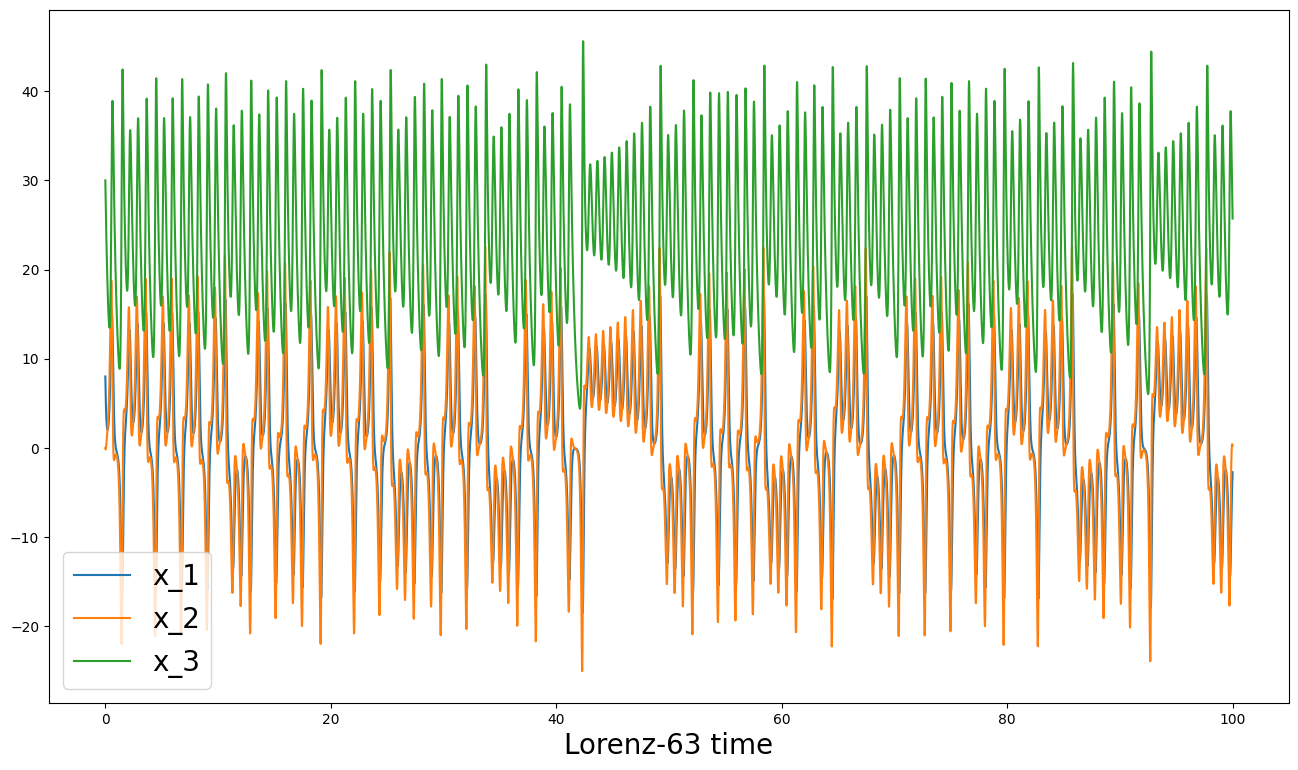

In [70]:
# Time series representation
plot(time, x)
xlabel('Lorenz-63 time', size=20)
legend(['x_1','x_2','x_3'], fontsize=20)

Text(0.5, 0, '$x_3$')

/usr/local/lib/python3.10/dist-packages/mpl_toolkits/mplot3d/proj3d.py:210: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/usr/local/lib/python3.10/dist-packages/mpl_toolkits/mplot3d/proj3d.py:210: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


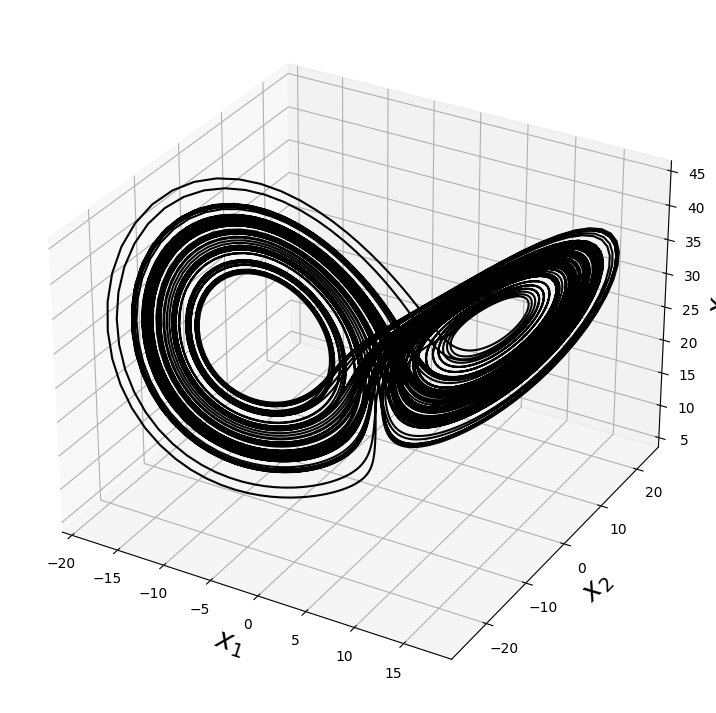

In [71]:
# Phase-space representation
from mpl_toolkits.mplot3d import Axes3D
fig = figure()
#ax = fig.gca(projection='3d')
ax = fig.add_subplot(projection = '3d')
ax.plot(x[:,0], x[:,1], x[:,2], 'k')
ax.set_xlabel('$x_1$', size=20)
ax.set_ylabel('$x_2$', size=20)
ax.set_zlabel('$x_3$', size=20)

**Create the training and test datasets**

Here, we want to predict the Lorenz-63 system at time t using the previous information at time t-0.01. It is thus a regression between the process and himself with a time delay. Here, we create a training (the first 2/3 of time series) and a test dataset (the last part).

In [72]:
# Size of the training set
T_train = int(T/dt*2/3)

# Training set
x_train = x[0:T_train,:]
y_train = x[1:T_train+1,:]

# Validation set
x_test = x[T_train+1:-1,]
y_test = x[T_train+2:,]

**Question 1:**

For the 3 components of the Lorenz-63 system, plot *y_train* as a function of *x_train* and comment the relationship. What is happening if we increase the time delay (currently set to $0.01$) between *x_train* and *y_train*?

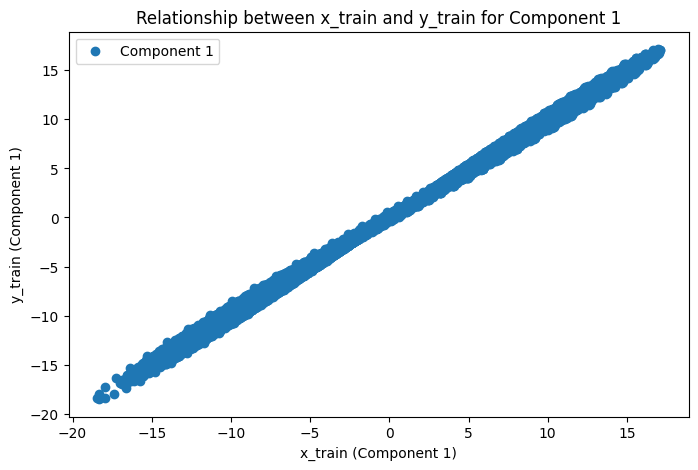

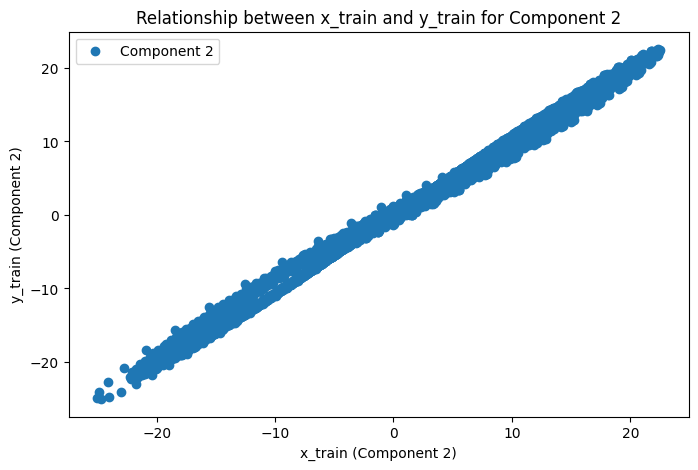

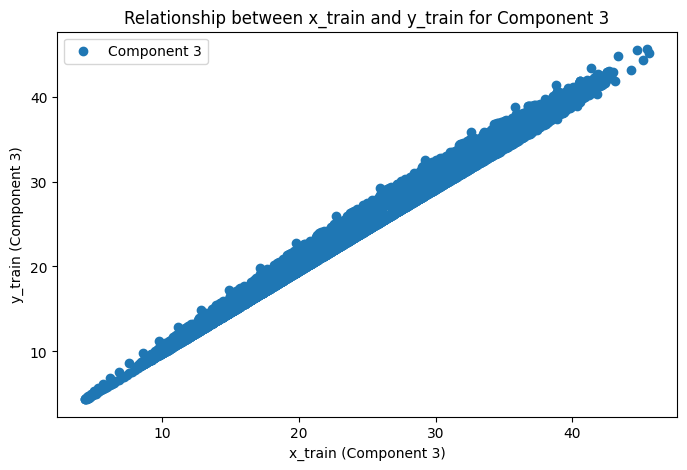

In [73]:
# Question 1
import matplotlib.pyplot as plt

for i in range(3):
    plt.figure(figsize=(8, 5))
    plt.scatter(x_train[:-1, i], y_train[:-1, i], label=f'Component {i+1}')
    plt.xlabel(f'x_train (Component {i+1})')
    plt.ylabel(f'y_train (Component {i+1})')
    plt.legend()
    plt.title(f'Relationship between x_train and y_train for Component {i+1}')
    plt.show()

**Response:**

The scatter plots show the relationship between x_train (at time t-0.01) and y_train (at time t) for each component. There is a clear linear relationship between x_train and y_train for each component. Increasing the time delay may reduce the linearity of the relationship, as it would introduce more time steps between x_train and y_train, making the prediction less accurate.

**Question 2:**

According to the previous question, propose a linear regression between *y_train* (at time t) and *x_train* (at time t-0.01). It corresponds to a multivariate order 1 autoregressive process noted AR(1), see more details here (https://en.wikipedia.org/wiki/Autoregressive_model).

Implement the AR(1) regression using a neural network architecture (see lab session 1 & 2). Call your model *model_AR1*. Can you comment the estimated weights of the resulting neural network?

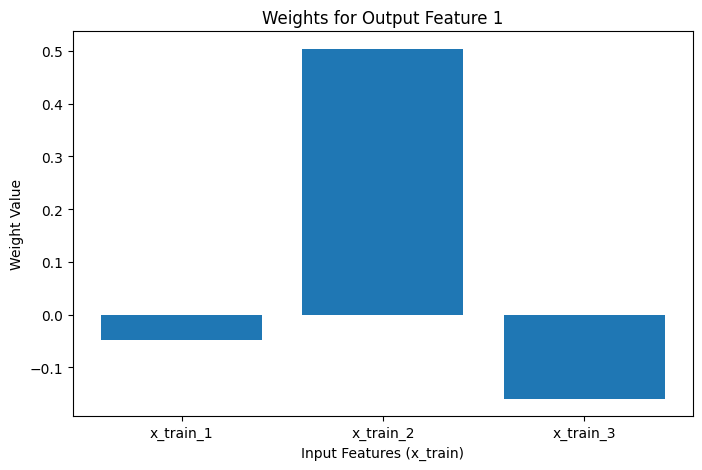

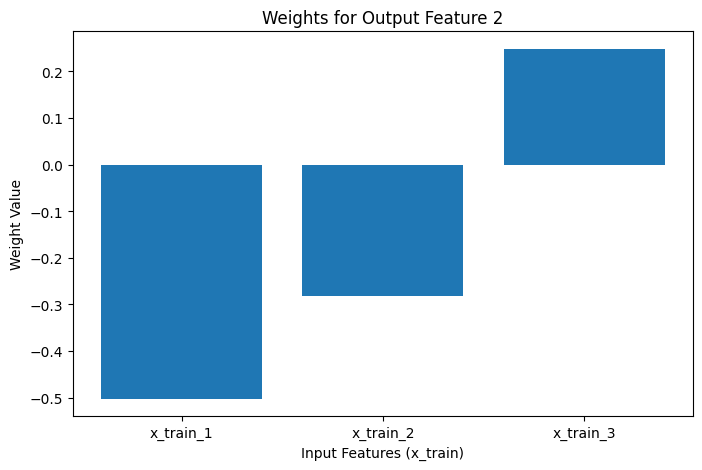

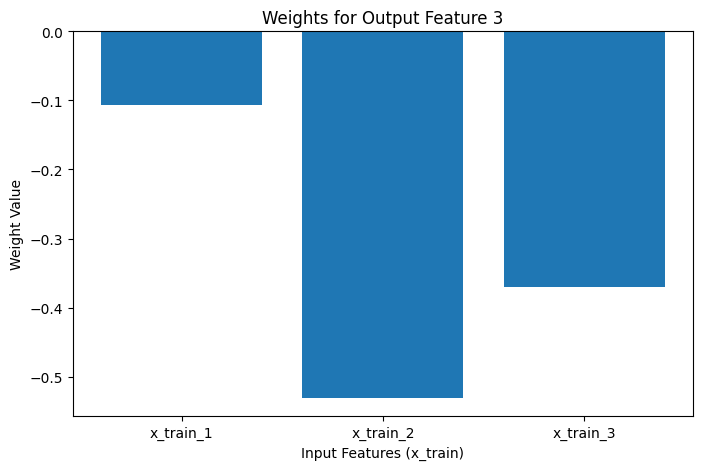

In [74]:
# Question 2
# Implement the AR(1) regression using a neural network architecture.
# Call your model model_AR1. Can you comment the estimated weights of the resulting neural network?

class AR1Model(nn.Module):
    def __init__(self, input_size, output_size):
        super(AR1Model, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Create the AR(1) model with 3 input features (x_train at time t-0.01) and 3 output features (y_train at time t)
model_AR1 = AR1Model(3, 3)

# Get the model weights
model_weights = model_AR1.linear.weight.data.numpy()

# Visualize the weights
for i in range(3):  # Loop through output features (y_train)
    plt.figure(figsize=(8, 5))
    plt.bar(range(3), model_weights[i, :])
    plt.xlabel(f'Input Features (x_train)')  # x-axis label
    plt.ylabel(f'Weight Value')  # y-axis label
    plt.title(f'Weights for Output Feature {i + 1}')  # Title for the plot
    plt.xticks(range(3), [f'x_train_{j+1}' for j in range(3)])  # Set x-axis labels
    plt.show()

**Response:**

The AR(1) model is a simple linear regression model. It has a linear layer with weights and biases that are learned during training.
The weights represent the relationships between the input features (x_train) at time t-0.01 and the output features (y_train) at time t.
These weights determine how much each input feature contributes to predicting the output feature.

**Question 3:**

Now, use a RNN architecture to learn the variations of the time series. To do so, we use the *LSTM()* function from PyTorch. Below, we provide you the dataset and a LSTM class. Here, we recommend that you use GPU acceleration.

After implementing and fitting your RNN, have a look at the estimated parameters: what do they represent? See https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html for more details.

First, we have to rearange the dataset used to train the RNN. We also store the dataset on the GPU.

In [75]:
# Reshape train and test data (with batch_size = 1)
x_train_LSTM = reshape(x_train, (shape(x_train)[0], 1, shape(x_train)[1]))
x_test_LSTM = reshape(x_test, (shape(x_test)[0], 1, shape(x_test)[1]))
y_train_LSTM = reshape(y_train, (shape(y_train)[0], 1, shape(y_train)[1]))
y_test_LSTM = reshape(y_test, (shape(y_test)[0], 1, shape(y_test)[1]))

# Store the data on the GPU
x_train_LSTM, x_test_LSTM = x_train_LSTM.to(device), x_test_LSTM.to(device)
y_train_LSTM, y_test_LSTM = y_train_LSTM.to(device), y_test_LSTM.to(device)

Then, we suggest to use the following RNN architecture with one LSTM layer and a fully connected layer with linear activation.

In [76]:
# Declare a class for LSTM
class LSTM_nn(nn.Module):

    # class initialization
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_nn, self).__init__()
        # LSTM layer with 1 hidden layer (hidden_size neurons inside)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers = 1)
        # fully connected layer with linear activation
        self.fc = nn.Linear(hidden_size, output_size)

    # function to apply the neural network
    def forward(self, x):
        out, (h_out, c_out) = self.lstm(x)
        y_pred = self.fc(out)
        return y_pred, h_out, c_out

    # function to apply the neural network (when knowing the hidden state)
    def forward_using_last_hidden_layer(self, x, h, c):
        out, (h_out, c_out) = self.lstm(x, (h, c))
        y_pred = self.fc(out)
        return y_pred, h_out, c_out

In the next cell, we initialize a LSTM with 10 neurons in the hidden layer. Here, we transfer the LSTM model to the GPU.

In [77]:
# Create the LSTM (3 input size for x and 3 output size for y, 10 neurons in the hidden layer)
model_RNN = LSTM_nn(3, 10, 3)

# Use the GPU to train the model
model_RNN.to(device)

LSTM_nn(
  (lstm): LSTM(3, 10)
  (fc): Linear(in_features=10, out_features=3, bias=True)
)

Then, you will have to optimize the LSTM. We suggest to carrefully check the loss function along the epochs. The number of epoch needed to converge can be large, depending on the optimizer and the learning rate.

In [78]:
# Question 3

# Define the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create the LSTM (3 input size for x and 3 output size for y, 10 neurons in the hidden layer)
model_RNN = LSTM_nn(3, 10, 3)

# Use the GPU to train the model
model_RNN.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model_RNN.parameters(), lr=0.001)

# Train the RNN model
num_epochs = 1000

for epoch in range(num_epochs):
    outputs, _, _ = model_RNN(x_train_LSTM)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_LSTM)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [100/1000], Loss: 235.5489
Epoch [200/1000], Loss: 202.6764
Epoch [300/1000], Loss: 174.7305
Epoch [400/1000], Loss: 158.6305
Epoch [500/1000], Loss: 145.6578
Epoch [600/1000], Loss: 134.4561
Epoch [700/1000], Loss: 124.5097
Epoch [800/1000], Loss: 115.5896
Epoch [900/1000], Loss: 107.5536
Epoch [1000/1000], Loss: 100.2916


**Response:**

The RNN model consists of an LSTM layer followed by a fully connected layer. The LSTM layer has hidden neurons that capture the temporal dependencies in the time series data. The weights and biases of both layers are learned during training. The estimated parameters represent the weights and biases that minimize the mean squared error (MSE) between the model's predictions and the ground truth (y_train).

The decreasing loss during training in each epoch indicates that the model is learning and improving its predictive abilities over time.

**Question 4:**

Compare the predictions of the linear regression AR(1) and the LSTM architecture on the test dataset. Compute the root mean squared errors (for each component) between the predicted values and the truth. Plot also the histograms of the residuals (difference between prediction and truth) for the 2 models. What are the main differences between the ouputs of the AR(1) and the RNN models?

First, you have to transfer the prediction of your LSTM from the GPU.

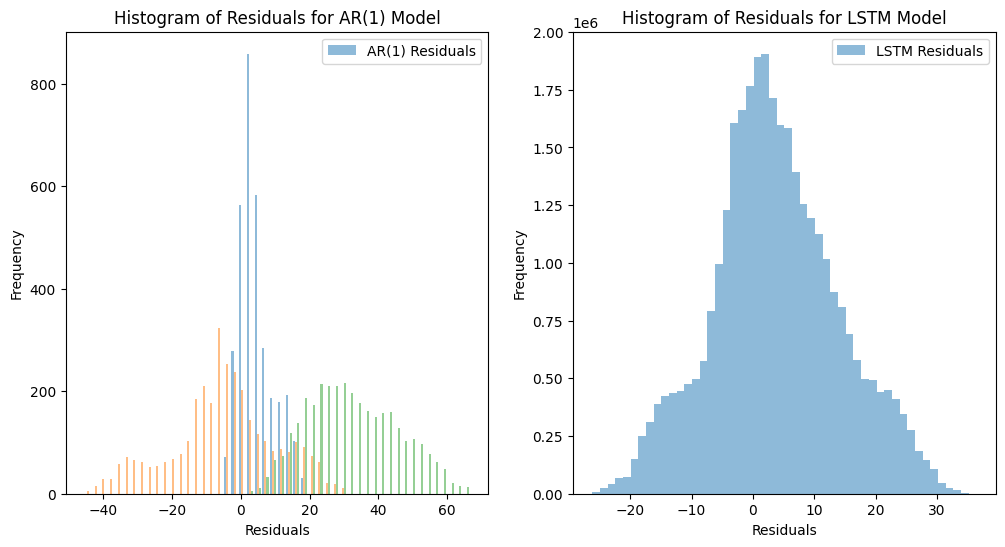

In [79]:
# Make predictions from the AR1 and LSTM models
y_AR1_hat = model_AR1.forward(x_test)
y_RNN_hat, h_hat, c_hat = model_RNN.forward(x_test_LSTM)

# Transfer data from the GPU
#y_RNN_hat = y_RNN_hat.cpu()

# Convert the predictions and y_test to NumPy arrays
y_AR1_hat = y_AR1_hat.detach().numpy()
y_RNN_hat = y_RNN_hat.cpu().detach().numpy()
y_test_numpy = y_test.cpu().numpy()

# Compute root mean squared errors
import numpy as np

def calculate_rmse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return np.sqrt(mse)

rmse_AR1 = calculate_rmse(y_test_numpy, y_AR1_hat)
rmse_RNN = calculate_rmse(y_test_numpy, y_RNN_hat)

# Flatten residuals_RNN
residuals_AR1 = y_test_numpy - y_AR1_hat
residuals_RNN = y_test_numpy - y_RNN_hat
residuals_RNN = residuals_RNN.flatten()  # Flatten the residuals array

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.hist(residuals_AR1, bins=50, alpha=0.5, label='AR(1) Residuals')
ax1.set_xlabel('Residuals')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Residuals for AR(1) Model')
ax1.legend()

ax2.hist(residuals_RNN, bins=50, alpha=0.5, label='LSTM Residuals')
ax2.set_xlabel('Residuals')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of Residuals for LSTM Model')
ax2.legend()

plt.show()


**Response:**



**Question 5:**

Now, starting from the last value of *y_test*, use the AR(1) model and the RNN to simulate new data (e.g., a sequence of 1500 time steps). You will need to apply the models recursively. Comment the resulting trajectories: do they look like the original ones?

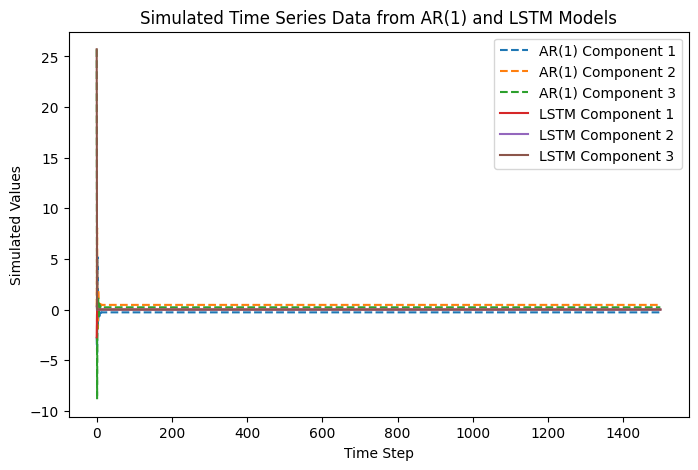

In [80]:
len_simu = 1500  # length of the simulation
x0_AR1 = y_test[-1, :]  # initial condition for AR(1)
x0_LSTM = y_test_LSTM[-1, :, :]  # initial condition for LSTM (needed to learn the neurons in the hidden layer)

# Initialize resulting arrays
x_AR1 = torch.zeros((len_simu, 3))
x_RNN = torch.zeros((len_simu, 3)).to(device)
x_AR1[0, :] = x0_AR1
x_RNN[0, :] = x0_LSTM[-1, :]

# Loop on the previous prediction
for i in range(len_simu - 1):
    x_AR1[i + 1, :] = model_AR1(x_AR1[i, :])
    x_RNN_tmp, _, _ = model_RNN.forward_using_last_hidden_layer(x_RNN[i, :].unsqueeze(0).unsqueeze(0), h_hat, c_hat)
    x_RNN[i + 1, :]

import matplotlib.pyplot as plt

# Plot the AR(1) and RNN (LSTM) simulations
plt.figure(figsize=(8, 5))
plt.plot(x_AR1[:, 0].detach().numpy(), label='AR(1) Component 1', linestyle='--')
plt.plot(x_AR1[:, 1].detach().numpy(), label='AR(1) Component 2', linestyle='--')
plt.plot(x_AR1[:, 2].detach().numpy(), label='AR(1) Component 3', linestyle='--')

plt.plot(x_RNN[:, 0].cpu().detach().numpy(), label='LSTM Component 1')
plt.plot(x_RNN[:, 1].cpu().detach().numpy(), label='LSTM Component 2')
plt.plot(x_RNN[:, 2].cpu().detach().numpy(), label='LSTM Component 3')

plt.xlabel('Time Step')
plt.ylabel('Simulated Values')
plt.legend()
plt.title('Simulated Time Series Data from AR(1) and LSTM Models')
plt.show()

**Response:**

No,

**Question 6 (bonus):**

Propose and implement a new model to increase the quality of the prediction. We suggest to transform the input and take into account more time lags (i.e., $t-1$, $t-2$, $t-3$) to explain the Lorenz-63 system at time $t$. This can be done using a linear regression and in that case, we are talking about a AR(3) model.

In [81]:
class AR3Model(nn.Module):
    def __init__(self, input_size, output_size):
        super(AR3Model, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Move the model to the GPU (if it's not already on the GPU)
model_AR3.to(device)

# Combine the time lags for x_train_AR3
x_train_AR3 = torch.cat((x_train[:-3], x_train[1:-2], x_train[2:-1]), dim=1)
y_train_AR3 = x_train[3:]  # Shift y_train_AR3 accordingly

# Move x_train_AR3 and y_train_AR3 to the same device as the model (GPU)
x_train_AR3 = x_train_AR3.to(device)
y_train_AR3 = y_train_AR3.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model_AR3.parameters(), lr=0.001)

# Train the AR(3) model
num_epochs = 1000

for epoch in range(num_epochs):
    outputs = model_AR3(x_train_AR3)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_AR3)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Comment:



Epoch [100/1000], Loss: 0.9927
Epoch [200/1000], Loss: 0.7880
Epoch [300/1000], Loss: 0.6250
Epoch [400/1000], Loss: 0.4927
Epoch [500/1000], Loss: 0.3845
Epoch [600/1000], Loss: 0.2965
Epoch [700/1000], Loss: 0.2257
Epoch [800/1000], Loss: 0.1696
Epoch [900/1000], Loss: 0.1260
Epoch [1000/1000], Loss: 0.0926


The AR(3) model considers more time lags (t-1, t-2, t-3) by adjusting the input and output dimensions. The training process is similar to the AR(1) model, but the input and output data structures are adapted to include the time lags. The  model captured more complex temporal dependencies and improved the quality of the predictions.